# Etiquetado de los registros

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

El objetivo de este notebook es asignar a cada registro una etiqueta binaria de acuerdo al comportamiento de cada valor en cada periodo temporal con respecto a un índice de referencia. Este índice lo vamos a construir como una media de las variaciones de precios de un grupo de valores representativos.

De este modo, cuando un valor se comporte mejor que el índice (ya sea porque, porcentualmente, su precio sube más, o porque baja menos) le asignaremos la etiqueta 'mejor'. En caso contrario la etiqueta será 'peor'.

Para nuestro análisis disponemos del campo 'Adj. Close', que se trata del precio de cierre descontando los efectos de acciones corporativas como pago de dividendos, splits, etc., ideal para un análisis a largo plazo como el nuestro.

## Obtención de un índice

Intentamos identificar un grupo homogéneo de valores presente en un periodo de tiempo razonable, lo usaremos para calcular el índice de referencia y como población para aplicar nuestro modelo.

Los precios los normalizaremos en base 100 con respecto al precio del primer trimestre.

El índice de referencia, será la media de estos precios en base 100.

Partimos de la tablas generada mergedbalres y lso datos de precios en banks_cotiz

### 1) Analizamos los registros de la tabla 'mergedbalres' para identificar el mejor grupo homogéneo de estudio

In [3]:
df_valores = pd.read_csv('../tablas/mergedbalres.csv', index_col='Ref')

df_valores['Publish Date']=pd.to_datetime(df_valores['Publish Date'], format="%Y-%m-%d")

In [4]:
# Creamos un campo 'Periodo' formado por el año y el trimestre correspondiente a cada registro
df_valores = df_valores.astype({'Fiscal Year':str})
df_valores['Periodo'] = df_valores['Fiscal Year'] + df_valores['Fiscal Period']

In [5]:
df_valores.groupby('Periodo').Ticker.count()

Periodo
2008Q3     2
2008Q4     2
2009Q1     2
2009Q2     9
2009Q3    12
2009Q4    15
2010Q1    15
2010Q2    21
2010Q3    23
2010Q4    26
2011Q1    26
2011Q2    38
2011Q3    39
2011Q4    38
2012Q1    38
2012Q2    39
2012Q3    40
2012Q4    42
2013Q1    42
2013Q2    42
2013Q3    42
2013Q4    42
2014Q1    42
2014Q2    42
2014Q3    43
2014Q4    43
2015Q1    43
2015Q2    45
2015Q3    45
2015Q4    45
2016Q1    45
2016Q2    46
2016Q3    46
2016Q4    46
2017Q1    46
2017Q2    45
2017Q3    45
2017Q4    45
2018Q1    45
2018Q2    47
2018Q3    46
2018Q4    48
2019Q1    47
2019Q2     1
Name: Ticker, dtype: int64

Eliminamos los periodos con menos valores y a continuación aplicamos un bucle para encontrar los valores presentes en todos los periodos desde 2011Q2 hasta 2019Q1.

In [6]:
df_valores=df_valores[df_valores.Periodo != '2019Q2']
df_valores=df_valores[df_valores.Periodo != '2008Q3']
df_valores=df_valores[df_valores.Periodo != '2008Q4']
df_valores=df_valores[df_valores.Periodo != '2009Q1']
df_valores=df_valores[df_valores.Periodo != '2009Q2']
df_valores=df_valores[df_valores.Periodo != '2009Q3']
df_valores=df_valores[df_valores.Periodo != '2009Q4']
df_valores=df_valores[df_valores.Periodo != '2010Q1']
df_valores=df_valores[df_valores.Periodo != '2010Q2']
df_valores=df_valores[df_valores.Periodo != '2010Q3']
df_valores=df_valores[df_valores.Periodo != '2010Q4']
df_valores=df_valores[df_valores.Periodo != '2011Q1']

In [7]:
for i,periodo in enumerate(df_valores.Periodo.unique()):
    if i == 0:
        valores=set(df_valores[df_valores.Periodo==periodo]['Ticker'])
    else:
        valores = valores & set(df_valores[df_valores.Periodo==periodo]['Ticker'])
len(valores)

34

Hemos obtenido un set con 34 valores presentes en los 32 periodos consecutivos desde 2011Q2 hasta 2019Q1.

### 2) Vamos a tratar el fichero banks_cotiz para filtrar por el periodo y acotado y normalizar todos los precios en base 100

In [8]:
df_precios = pd.read_csv('../datos/banks_cotiz.csv', sep=',', 
                         date_parser='Dates', usecols=('Ticker', 'Date', 'Adj. Close'))

# Filtramos por los Tickers en el set 'valores' y nos quedamos como fecha inicial el 1 de julio de 2011
df_precios=df_precios[df_precios['Ticker'].isin(list(valores))].reset_index(drop=True)
df_precios= df_precios[(df_precios['Date']>'2011-03-31')].reset_index(drop=True)

# Nos aseguramos de que la tabla está ordenada por Ticker y por fecha
df_precios.sort_values(['Ticker','Date'], ascending=True, inplace=True)
df_precios=df_precios.reset_index(drop=True)

# Pasamos el campo 'Date' a datetime y lo establecemos como índice
df_precios['Date']=pd.to_datetime(df_precios['Date'], format="%Y-%m-%d")
df_precios.set_index('Date', inplace = True)

In [9]:
a=df_precios.groupby('Date').count()
a

,Ticker,Adj. Close
Date,,
2011-04-01,34,34
2011-04-04,34,34
2011-04-05,34,34
2011-04-06,34,34
2011-04-07,34,34
...,...,...
2019-08-26,34,34
2019-08-27,34,34
2019-08-28,34,34


### Rellenado de fechas

El fichero de precios sólo incluye datos para los días con negociación, excluyendo fines de semana y festivos. Para evitar problemas sobre todo a la hora de obtener los precios futuros, vamos a incluir todos los días del calendario, rellenando el campo de precio con el del último día disponible.

In [10]:
df_precios.rename(columns={'Ticker':'Ticker_b'}, inplace=True)


table_1=pd.DataFrame()
for ticker in df_precios['Ticker_b'].unique():
    aux_table=df_precios[df_precios['Ticker_b']==ticker]
    aux_table2=aux_table.asfreq('D')
    aux_table2['Ticker'] = aux_table['Ticker_b'].asfreq('D', method='ffill')
    aux_table2['Precio'] = aux_table['Adj. Close'].asfreq('D', method='ffill')
    table_1=table_1.append(aux_table2)
df_precios=table_1

df_precios.drop(['Ticker_b','Adj. Close'], axis=1, inplace=True)

In [11]:
#Añadimos un nuevo campo con los precios de cada valor en base 100

table_1=pd.DataFrame()
for ticker in df_precios.Ticker.unique():
    aux_table=df_precios[df_precios.Ticker==ticker]
    aux_table['Price_b100']=(aux_table['Precio']*100)/aux_table['Precio'].iloc[0]
    table_1=table_1.append(aux_table)
    
df_precios=table_1
df_precios[df_precios.Ticker=='C']

/home/pipe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Ticker,Precio,Price_b100
Date,,,
2011-04-01,C,39.94,100.000000
2011-04-02,C,39.94,100.000000
2011-04-03,C,39.94,100.000000
2011-04-04,C,39.76,99.549324
2011-04-05,C,40.12,100.450676
...,...,...,...
2019-08-26,C,60.56,151.627441
2019-08-27,C,59.54,149.073610
2019-08-28,C,60.22,150.776164


## 3) Creamos una tabla que recoge el índice calculado como la media de los precios en base 100 de los 34 valores

In [12]:
df_indice=df_precios[df_precios['Ticker'].isin(list(valores))].reset_index(drop=True)
df_indice=df_precios.Price_b100.resample('D').mean()
df_indice

Date
2011-04-01    100.000000
2011-04-02    100.000000
2011-04-03    100.000000
2011-04-04    100.123144
2011-04-05     99.868119
                 ...    
2019-08-26    219.253485
2019-08-27    216.096200
2019-08-28    219.315863
2019-08-29    223.537505
2019-08-30    224.191960
Freq: D, Name: Price_b100, Length: 3074, dtype: float64

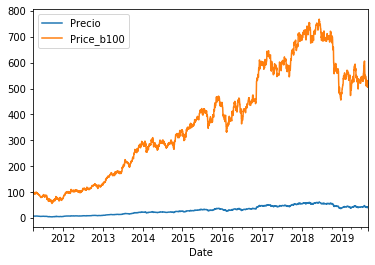

In [12]:
df_precios[df_precios.Ticker=='WAL'].plot()

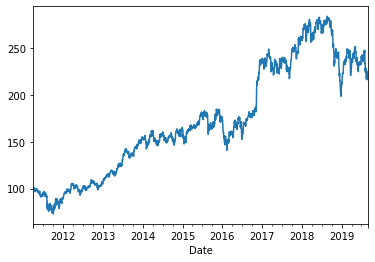

In [13]:
df_indice.plot()

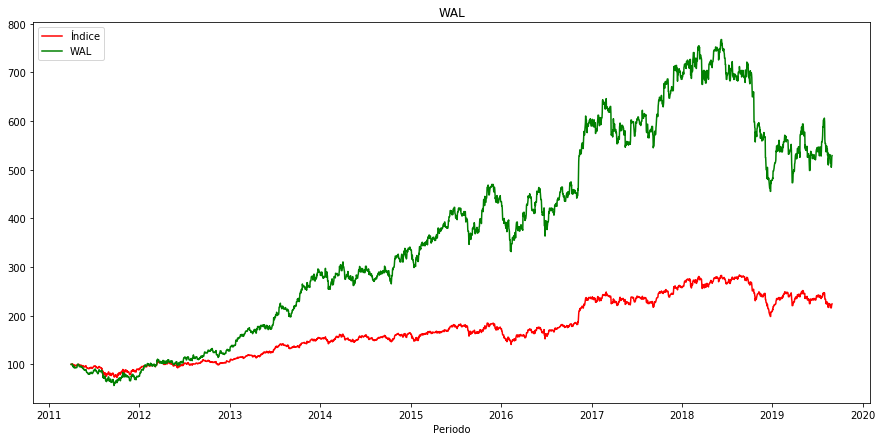

In [14]:
Banco = 'WAL'

xs = df_precios[df_precios['Ticker']==Banco].index
ys1 = df_indice
ys2 = df_precios[df_precios['Ticker']==Banco]['Price_b100']
 
fig = plt.figure(figsize=(15,7))
 
plt.plot(xs,ys1,color='r')
plt.plot(xs,ys2,color='g')

hight=800
#plt.xticks(xs,rotation=50)
 
plt.title(Banco)
plt.xlabel('Periodo')
 
    
plt.legend(['Índice','%s'%(Banco)],loc='upper left')
     
plt.show()

### 4) Incorporamos en la tabla de valores los precios en base 100 de cada valor y del índice correspondientes a la fecha de publicación de cuentas (d) y 180 días después (d+180)

In [13]:
# Filtramos por los Tickers en el set 'valores' y nos quedamos como fecha inicial el 1 de abril de 2011
df_valores=df_valores[df_valores['Ticker'].isin(list(valores))].reset_index(drop=True)
df_valores= df_valores[(df_valores['Publish Date']>'2011-03-31')].reset_index(drop=True)
df_valores

,Ticker,SimFinId,Currency,Fiscal Year,Fiscal Period,Report Date,Publish Date,Restated Date,Shares (Basic),Shares (Diluted),...,Total Non-Interest Expense,Operating Income (Loss),Non-Operating Income (Loss),Pretax Income (Loss),"Income Tax (Expense) Benefit, Net",Income (Loss) from Continuing Operations,Net Extraordinary Gains (Losses),Net Income,Net Income (Common),Periodo
0,C,89126,USD,2011,Q2,2011-06-30,2011-08-05,2011-08-05,2.908600e+09,2.997000e+09,...,-12936000000,4299000000,NaN,4299000000,-9.670000e+08,3332000000,71000000.0,3341000000,3341000000,2011Q2
1,C,89126,USD,2011,Q3,2011-09-30,2011-11-04,2011-11-04,2.910800e+09,2.998600e+09,...,-12460000000,5020000000,NaN,5020000000,-1.278000e+09,3742000000,1000000.0,3771000000,3771000000,2011Q3
2,C,89126,USD,2011,Q4,2011-12-31,2012-02-24,2013-03-01,2.915400e+09,3.003000e+09,...,-12528000000,1187000000,NaN,1187000000,-1.450000e+08,1042000000,-44000000.0,956000000,956000000,2011Q4
3,C,89126,USD,2012,Q1,2012-03-31,2012-05-04,2012-05-04,2.926200e+09,3.014500e+09,...,-12319000000,4068000000,NaN,4068000000,-1.006000e+09,3062000000,-5000000.0,2931000000,2931000000,2012Q1
4,C,89126,USD,2012,Q2,2012-06-30,2012-08-03,2012-08-03,2.926600e+09,3.015000e+09,...,-11994000000,3697000000,NaN,3697000000,-7.180000e+08,2979000000,7000000.0,2946000000,2946000000,2012Q2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1083,WSBC,739365,USD,2018,Q1,2018-03-31,2018-04-30,2018-04-30,4.405070e+07,4.416824e+07,...,-54326000,40778000,NaN,40533000,-7.004000e+06,33529000,NaN,33529000,33529000,2018Q1
1084,WSBC,739365,USD,2018,Q2,2018-06-30,2018-07-30,2018-07-30,4.649830e+07,4.663978e+07,...,-58131000,45916000,NaN,40504000,-7.335000e+06,33169000,NaN,33169000,33169000,2018Q2
1085,WSBC,739365,USD,2018,Q3,2018-09-30,2018-11-02,2018-11-02,5.027785e+07,5.043211e+07,...,-65309000,49813000,NaN,39002000,-6.516000e+06,32486000,NaN,32486000,32486000,2018Q3
1086,WSBC,739365,USD,2018,Q4,2018-12-31,2019-03-01,2019-05-01,5.472931e+07,5.485183e+07,...,-69598000,55877000,NaN,54485000,-1.055700e+07,43928000,NaN,43928000,43928000,2018Q4


In [14]:
# Incorporamos el precio de cada valor (campo 'Price_b100) a la tabla df_valores con la función merged
df_valores = df_valores.merge(df_precios, 
                              left_on=('Ticker','Publish Date'),
                              right_on=('Ticker','Date'), 
                              how='left')
#df_valores.drop(['Precio'], axis=1, inplace=True)

df_valores.rename(columns={'Price_b100':'Price_d_100','Precio':'Price_d'}, inplace=True)

In [15]:
df_valores.tail(5)

,Ticker,SimFinId,Currency,Fiscal Year,Fiscal Period,Report Date,Publish Date,Restated Date,Shares (Basic),Shares (Diluted),...,Non-Operating Income (Loss),Pretax Income (Loss),"Income Tax (Expense) Benefit, Net",Income (Loss) from Continuing Operations,Net Extraordinary Gains (Losses),Net Income,Net Income (Common),Periodo,Price_d,Price_d_100
1083,WSBC,739365,USD,2018,Q1,2018-03-31,2018-04-30,2018-04-30,44050701.0,44168242.0,...,NaN,40533000,-7004000.0,33529000,NaN,33529000,33529000,2018Q1,40.29,256.624204
1084,WSBC,739365,USD,2018,Q2,2018-06-30,2018-07-30,2018-07-30,46498305.0,46639780.0,...,NaN,40504000,-7335000.0,33169000,NaN,33169000,33169000,2018Q2,45.02,286.751592
1085,WSBC,739365,USD,2018,Q3,2018-09-30,2018-11-02,2018-11-02,50277847.0,50432112.0,...,NaN,39002000,-6516000.0,32486000,NaN,32486000,32486000,2018Q3,38.27,243.757962
1086,WSBC,739365,USD,2018,Q4,2018-12-31,2019-03-01,2019-05-01,54729311.0,54851826.0,...,NaN,54485000,-10557000.0,43928000,NaN,43928000,43928000,2018Q4,39.75,253.184713
1087,WSBC,739365,USD,2019,Q1,2019-03-31,2019-05-01,2019-05-01,54598499.0,54706337.0,...,NaN,49195000,-8858000.0,40337000,NaN,40337000,40337000,2019Q1,37.71,240.191083


In [16]:
from datetime import timedelta
#Creamos un nuevo campo a partir de la fecha de publicación y le añadimos 180 días.

df_valores['Publish_Date+180']=df_valores['Publish Date'] + timedelta(days=180)

In [17]:
#Cruzamos ambas tablas

df_valores = df_valores.merge(df_precios, 
                              left_on=('Ticker','Publish_Date+180'),
                              right_on=('Ticker','Date'), 
                              how='left')

#df_valores.drop(['Precio'], axis=1, inplace=True)

df_valores.rename(columns={'Price_b100':'Price_d+180_100','Precio':'Price_d+180'}, inplace=True)

In [18]:
df_valores.head(5)

,Ticker,SimFinId,Currency,Fiscal Year,Fiscal Period,Report Date,Publish Date,Restated Date,Shares (Basic),Shares (Diluted),...,Income (Loss) from Continuing Operations,Net Extraordinary Gains (Losses),Net Income,Net Income (Common),Periodo,Price_d,Price_d_100,Publish_Date+180,Price_d+180,Price_d+180_100
0,C,89126,USD,2011,Q2,2011-06-30,2011-08-05,2011-08-05,2.908600e+09,2.997000e+09,...,3332000000,71000000.0,3341000000,3341000000,2011Q2,30.03,75.187782,2012-02-01,28.38,71.056585
1,C,89126,USD,2011,Q3,2011-09-30,2011-11-04,2011-11-04,2.910800e+09,2.998600e+09,...,3742000000,1000000.0,3771000000,3771000000,2011Q3,27.25,68.227341,2012-05-02,29.38,73.560341
2,C,89126,USD,2011,Q4,2011-12-31,2012-02-24,2013-03-01,2.915400e+09,3.003000e+09,...,1042000000,-44000000.0,956000000,956000000,2011Q4,29.07,72.784176,2012-08-22,27.41,68.627942
3,C,89126,USD,2012,Q1,2012-03-31,2012-05-04,2012-05-04,2.926200e+09,3.014500e+09,...,3062000000,-5000000.0,2931000000,2931000000,2012Q1,28.40,71.106660,2012-10-31,33.62,84.176264
4,C,89126,USD,2012,Q2,2012-06-30,2012-08-03,2012-08-03,2.926600e+09,3.015000e+09,...,2979000000,7000000.0,2946000000,2946000000,2012Q2,24.63,61.667501,2013-01-30,37.73,94.466700


In [19]:
df_indice=pd.DataFrame(df_indice)

In [20]:
#Cruzamos la tabla de valores con los precios de df_índice

df_valores = df_valores.merge(df_indice, 
                              left_on=('Publish Date'),
                              right_on=('Date'), 
                              how='left')

df_valores.rename(columns={'Price_b100':'Indice_d_100'}, inplace=True)

df_valores = df_valores.merge(df_indice, 
                              left_on=('Publish_Date+180'),
                              right_on=('Date'), 
                              how='left')

df_valores.rename(columns={'Price_b100':'Indice_d+180_100'}, inplace=True)

In [21]:
#Eliminamos los últimos periodos para los que no hay precio en d+90

df_valores=df_valores[df_valores['Price_d+180_100'].notnull()]

In [27]:
df_indice.iloc[2000]

Price_b100    178.268806
Name: 2016-09-21 00:00:00, dtype: float64

### 5) Cálculo de las diferencias entre la evolución de los precios y la evolución del índice. Etiquetado a partir de dichas diferencias

In [24]:
df_valores['Var_cotiz']=(df_valores['Price_d+180_100']-df_valores['Price_d_100'])/df_valores['Price_d_100']
df_valores['Var_index']=(df_valores['Indice_d+180_100']-df_valores['Indice_d_100'])/df_valores['Indice_d_100']

In [25]:
def etiquetado(row):
    limite = 0.00
    dif = row['Var_cotiz'] - row['Var_index']
    if dif > limite:
        return 'Mejor'
    elif dif < limite:
        return 'Peor'
    else:
        return 'Error'

In [26]:
df_valores['Etiqueta']=df_valores.apply(etiquetado,axis=1)

In [27]:
df_valores.groupby('Etiqueta').count()

,Ticker,SimFinId,Currency,Fiscal Year,Fiscal Period,Report Date,Publish Date,Restated Date,Shares (Basic),Shares (Diluted),...,Periodo,Price_d,Price_d_100,Publish_Date+180,Price_d+180,Price_d+180_100,Indice_d_100,Indice_d+180_100,Var_cotiz,Var_index
Etiqueta,,,,,,,,,,,,,,,,,,,,,
Mejor,511,511,511,511,511,511,511,511,500,500,...,511,511,511,511,511,511,511,511,511,511
Peor,540,540,540,540,540,540,540,540,520,520,...,540,540,540,540,540,540,540,540,540,540


In [28]:
df_valores=df_valores[df_valores.Etiqueta != 'Error']

Por último, guardamos la tabla obtenida

In [29]:
df_valores.to_csv('../tablas/registros_etiq_normal.csv', index=False)

In [30]:
df_valores.tail(5)

,Ticker,SimFinId,Currency,Fiscal Year,Fiscal Period,Report Date,Publish Date,Restated Date,Shares (Basic),Shares (Diluted),...,Price_d,Price_d_100,Publish_Date+180,Price_d+180,Price_d+180_100,Indice_d_100,Indice_d+180_100,Var_cotiz,Var_index,Etiqueta
1082,WSBC,739365,USD,2017,Q4,2017-12-31,2018-02-27,2019-03-01,44037707.0,44132105.0,...,38.32,244.076433,2018-08-26,46.40,295.541401,270.293504,280.944522,0.210856,0.039405,Mejor
1083,WSBC,739365,USD,2018,Q1,2018-03-31,2018-04-30,2018-04-30,44050701.0,44168242.0,...,40.29,256.624204,2018-10-27,36.45,232.165605,268.697485,233.523352,-0.095309,-0.130906,Mejor
1084,WSBC,739365,USD,2018,Q2,2018-06-30,2018-07-30,2018-07-30,46498305.0,46639780.0,...,45.02,286.751592,2019-01-26,37.24,237.197452,275.407200,236.539202,-0.172812,-0.141129,Peor
1085,WSBC,739365,USD,2018,Q3,2018-09-30,2018-11-02,2018-11-02,50277847.0,50432112.0,...,38.27,243.757962,2019-05-01,37.71,240.191083,244.838295,245.086477,-0.014633,0.001014,Peor
1086,WSBC,739365,USD,2018,Q4,2018-12-31,2019-03-01,2019-05-01,54729311.0,54851826.0,...,39.75,253.184713,2019-08-28,32.57,207.452229,248.042568,219.315863,-0.180629,-0.115814,Peor


In [31]:
df_var_indice=pd.DataFrame(columns=['Periodo','Indice_d_100','Indice_d+180_100','Rent_indice'])
for periodo in df_valores.Periodo.unique():
    aux_table=df_valores[df_valores['Periodo']==periodo]
    df_var_indice=df_var_indice.append({'Periodo':periodo,
                                        'Indice_d_100':aux_table.Indice_d_100.mean(),
                                        'Indice_d+180_100':aux_table['Indice_d+180_100'].mean(),
                                        'Rent_indice':(aux_table['Indice_d+180_100'].mean()*100/(aux_table.Indice_d_100.mean())-100)},
                                         ignore_index=True)

In [32]:
df_var_indice

,Periodo,Indice_d_100,Indice_d+180_100,Rent_indice
0,2011Q2,85.446712,97.377288,13.962593
1,2011Q3,86.162284,102.377520,18.819412
2,2011Q4,97.365754,101.211930,3.950236
3,2012Q1,102.206891,104.503845,2.247357
4,2012Q2,100.426559,112.954443,12.474672
5,2012Q3,102.816106,118.758031,15.505280
6,2012Q4,114.211571,135.881108,18.973153
7,2013Q1,119.325598,143.346036,20.130163
8,2013Q2,139.435976,145.906951,4.640822
9,2013Q3,144.344565,148.789265,3.079229


In [33]:
df_var_indice.to_csv('../tablas/var_indice.csv', index=False)